In [1]:
import cv2
import os
import random
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pandas as pd

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

from torch.autograd import Variable

In [2]:
data_dir = '../data/'
images_dir = os.path.join(data_dir, 'classes')

In [3]:
labels_df = pd.read_csv(os.path.join(data_dir, 'gicsd_labels.csv'))

In [4]:
labels_df.columns = labels_df.columns.str.replace(' ', '') # strip whitespace e.g. ' LABEL' 
labels_df = labels_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace

In [5]:
labels_df.head()

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY


## Preprocess

In [9]:
# Create "classes" folder for each class with single-channel images

for class_ in labels_df['LABEL'].unique():
    os.mkdir(os.path.join(data_dir, 'classes', class_))

for index, row in labels_df.iterrows():
    image = cv2.imread(os.path.join(data_dir, 'images', row['IMAGE_FILENAME']))
    image = image[:,:,0]
    cv2.imwrite(os.path.join(data_dir, 'classes', row['LABEL'], row['IMAGE_FILENAME']), image)

## Train

In [6]:
# TODO balance classes in sampling

def load_split_train_test(datadir, valid_size=0.2, batch_size=126):
    _transformer = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
    train_data = datasets.ImageFolder(datadir, transform=_transformer)
    test_data = datasets.ImageFolder(datadir, transform=_transformer)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler, test_sampler = list(map(SubsetRandomSampler, [train_idx, test_idx]))
    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return train_loader, test_loader

trainloader, testloader = load_split_train_test(images_dir, 0.2)
classes = trainloader.dataset.classes
print(trainloader.dataset.classes)

['FULL_VISIBILITY', 'NO_VISIBILITY', 'PARTIAL_VISIBILITY']


In [8]:
_transformer = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
train_data = datasets.ImageFolder(images_dir, transform=_transformer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, len(trainloader.dataset.classes)),
                         nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
epochs = 10
steps = 100
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))
            print(f"Epoch {epoch + 1}/{epochs}.. "
                  f"Train loss: {running_loss / print_every:.3f}.. "
                  f"Test loss: {test_loss / len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy / len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 1.048.. Test loss: 3.235.. Test accuracy: 0.744
Epoch 1/10.. Train loss: 1.798.. Test loss: 1.776.. Test accuracy: 0.830
Epoch 1/10.. Train loss: 3.806.. Test loss: 1.047.. Test accuracy: 0.776
Epoch 1/10.. Train loss: 1.805.. Test loss: 0.846.. Test accuracy: 0.798
Epoch 1/10.. Train loss: 1.292.. Test loss: 0.968.. Test accuracy: 0.798
Epoch 1/10.. Train loss: 3.174.. Test loss: 1.317.. Test accuracy: 0.353
Epoch 2/10.. Train loss: 2.013.. Test loss: 1.033.. Test accuracy: 0.809
Epoch 2/10.. Train loss: 0.848.. Test loss: 1.360.. Test accuracy: 0.787
Epoch 2/10.. Train loss: 1.290.. Test loss: 1.197.. Test accuracy: 0.819
Epoch 2/10.. Train loss: 1.454.. Test loss: 1.206.. Test accuracy: 0.787
Epoch 2/10.. Train loss: 0.876.. Test loss: 0.735.. Test accuracy: 0.809
Epoch 2/10.. Train loss: 0.340.. Test loss: 0.658.. Test accuracy: 0.827
Epoch 3/10.. Train loss: 0.735.. Test loss: 0.574.. Test accuracy: 0.838
Epoch 3/10.. Train loss: 0.701.. Test loss: 0.498..

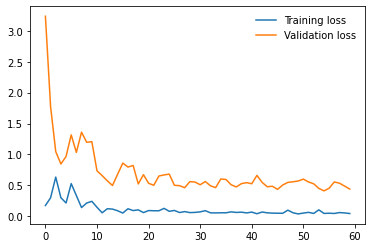

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Test

In [12]:
test_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

In [13]:
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
def get_random_test_images(num):
    data = datasets.ImageFolder(images_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def _plot_images(n_images, n_cols=5, size=(12, 18), title=None):
    """Helper function to plot sampled images"""
    to_pil = transforms.ToPILImage()
    n_rows = int(np.ceil(n_images / n_cols))
    images, labels = get_random_test_images(n_images)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=size)
    if title: fig.suptitle(title)
    axs = axs.flatten()
    for img, ax in zip(range(len(images)), axs):
        image = to_pil(images[img])
        index = predict_image(image)
        ax.imshow(image, cmap='gray')
        ax.set_title(str(classes[index]))

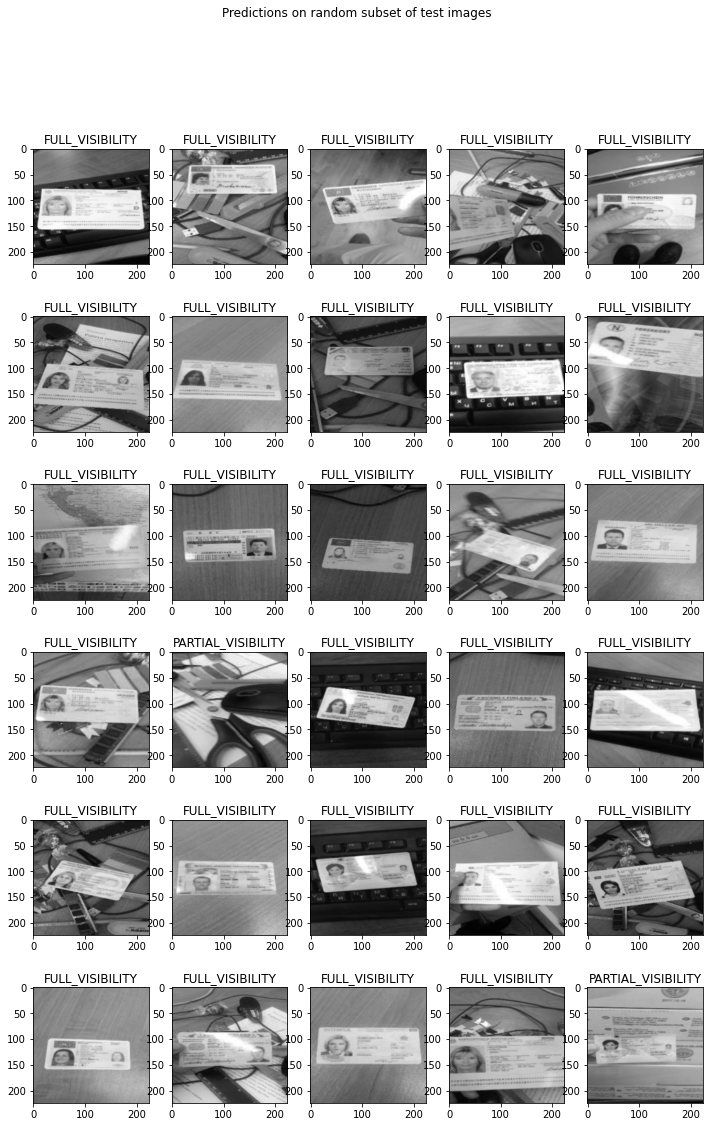

In [15]:
_plot_images(30, title='Predictions on random subset of test images')